In [4]:
from copy import deepcopy
import json
from pathlib import Path
import shutil

import higra as hg
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import plotly.express as px
from pylab import cm
import rasterio as rio
import scipy
from sklearn.metrics import silhouette_score


def compute_l2_dist(cube, labels, rows, cols):
    sum_l2_dist = 0
    for label in sorted(np.unique(labels).tolist()):
        mask1d = labels == label
        mask2d = mask1d.reshape(rows, cols)
        cluster_mean = cube[:, mask2d].mean(axis=1)
        diff = cube[:, mask2d].T - cluster_mean
        l2_dists = ((diff**2).sum(axis=1))**0.5
        sum_l2_dist += l2_dists.sum()
    return sum_l2_dist / (rows*cols)


def extract_labels(cluster_arr):
    labels = cluster_arr.copy()
    in_keys = list(reversed(sorted(np.unique(cluster_arr).tolist())))
    out_keys = list(range(1, len(in_keys)+1))
    for ix, in_key in enumerate(in_keys):
        mask1d = cluster_arr == in_key
        mask2d = mask1d.reshape(rows, cols)
        labels[mask1d] = out_keys[ix]
    return labels


def horizontal_cut(tree, altitudes, graph, k):
    explorer = hg.HorizontalCutExplorer(tree, altitudes)
    horizontal_cut_nodes = explorer.horizontal_cut_from_num_regions(k, at_least=True)
    cluster_arr = horizontal_cut_nodes.reconstruct_leaf_data(tree, altitudes, graph)
    return explorer, horizontal_cut_nodes, cluster_arr


def make_baseline_edges(cube, rows, cols, graph, n_adj):
    baseline_srcs = []
    baseline_srcs_tgts = []
    baseline_edges = set()
    dsts = []
    srcs = []
    for row in range(rows):
        for col in range(cols):
            temp_rows = np.random.choice(range(rows), size=rows//2, replace=False)
            temp_cols = np.random.choice(range(cols), size=cols//2, replace=False)
            temp_rows = [x for x in temp_rows if x != row]
            temp_cols = [x for x in temp_cols if x != col]
            
            dsts_ = [tuple(x) for x in zip(temp_rows, temp_cols)]
            srcs_ = (len(dsts_) * [(row, col)])
            srcs_dsts = tuple(zip(srcs_, dsts_))
            srcs_dsts = list(set([x for x in srcs_dsts if x not in baseline_edges]))[:n_adj]
            srcs_dsts = [x for x in srcs_dsts if x[0] != x[1]]
            for edge in srcs_dsts:            
                baseline_edges.add(edge)

    baseline_ix_df = pd.DataFrame(list(baseline_edges), columns=["rowcol1", "rowcol2"])
    baseline_ix_df["row1"] = baseline_ix_df["rowcol1"].apply(lambda x: x[0])
    baseline_ix_df["col1"] = baseline_ix_df["rowcol1"].apply(lambda x: x[1])
    baseline_ix_df["row2"] = baseline_ix_df["rowcol2"].apply(lambda x: x[0])
    baseline_ix_df["col2"] = baseline_ix_df["rowcol2"].apply(lambda x: x[1])
    baseline_ix_df.drop_duplicates(subset=["row1", "col1", "row2", "col2"], inplace=True)
    mirror = baseline_ix_df.copy()
    mirror.columns = ["rowcol2", "rowcol1", "row2", "col2", "row1", "col1"]
    mirror = mirror[list(baseline_ix_df)]
    row_mask1 = (baseline_ix_df["row1"] < baseline_ix_df["row2"])
    row_mask2 = (baseline_ix_df["row1"] == baseline_ix_df["row2"])
    col_mask = (baseline_ix_df["col1"] < baseline_ix_df["col2"])
    m1 = row_mask1 | (row_mask2 & col_mask)
    m2 = ~m1

    baseline_ix_df.loc[m1, "r1"] = baseline_ix_df.loc[m1, "row1"]
    baseline_ix_df.loc[m1, "c1"] = baseline_ix_df.loc[m1, "col1"]
    baseline_ix_df.loc[m1, "r2"] = baseline_ix_df.loc[m1, "row2"]
    baseline_ix_df.loc[m1, "c2"] = baseline_ix_df.loc[m1, "col2"]

    baseline_ix_df.loc[m2, "r1"] = baseline_ix_df.loc[m2, "row2"]
    baseline_ix_df.loc[m2, "c1"] = baseline_ix_df.loc[m2, "col2"]
    baseline_ix_df.loc[m2, "r2"] = baseline_ix_df.loc[m2, "row1"]
    baseline_ix_df.loc[m2, "c2"] = baseline_ix_df.loc[m2, "col1"]

    for col in ["r1", "c1", "r2", "c2"]:
        baseline_ix_df[col] = baseline_ix_df[col].astype(int)
    baseline_ix_df.drop_duplicates(subset=["r1", "c1", "r2", "c2"], inplace=True)

    delta = baseline_ix_df.shape[0] - len(edge_weights)
    if delta > 0:
        baseline_ix_df = baseline_ix_df.merge(
            baseline_ix_df.groupby("rowcol1")
            .row1
            .count()
            .rename("degree"), how="left", left_on="rowcol1", right_index=True
        )
        baseline_ix_df.sort_values("degree", ascending=True, inplace=True)
        baseline_ix_df = baseline_ix_df.head(len(baseline_ix_df) - delta)
        baseline_ix_df.sort_index(inplace=True)

    return [
        ((x[0], x[1]), (x[2], x[3]))
        for x in baseline_ix_df[["r1", "c1", "r2", "c2"]].values
    ]


def prep_edge_weights(edge_weights_: list, offset: float = 1e-5):
    edge_weights_ = np.array(edge_weights_)
    min_, max_ = edge_weights_.min(), edge_weights_.max()
    edge_weights_ = (edge_weights_ - min_) / (max_ - min_) + offset
    return edge_weights_


def tree_alts_cost(graph_, edge_weights_, linkage: str, mode="dissimilarity"):
    partition_func = getattr(hg, f"binary_partition_tree_{linkage}_linkage")
    tree_, altitudes_ = partition_func(graph_, edge_weights_)
    cost_ = hg.dasgupta_cost(tree_, edge_weights_, graph_, mode=mode)
    return tree_, altitudes_, cost_



In [5]:
data_dir = Path(r"C:\Users\Peter\gh\st-hc\data")
interim_dir = data_dir / "interim"
processed_dir = data_dir / "processed"
processed_phase1_dir = processed_dir / "phase1"
processed_figs_dir = processed_phase1_dir / "figs"
processed_stats_dir = processed_phase1_dir / "stats"
processed_figs_dir.mkdir(parents=True, exist_ok=True)
processed_stats_dir.mkdir(parents=True, exist_ok=True)

raw_dir = data_dir / "raw"
s2_cogs_dir = interim_dir / "s2_cogs"
regions_src = Path(r"C:\Users\Peter\gh\st-hc\regions.json")

with open(regions_src) as f:
    regions = json.load(f)

adj_map_2d = [
    [1, 0],  # row-down
    [0, 1],  # col-right
    [1, 1],  # row-down, col-right
    [1, -1],  # row-down, col-left
]
n_adj = len(adj_map_2d)


In [6]:
region_scene_selections = {
    'ae-abu-dhabi': "2017-01-04",
    'ar-rivadavia': "2020-07-19",
    'au-terangan': "2020-01-28",
    'bd-beacon-pharmaceuticals': "2022-12-22",
    'br-greater-sao-paolo': "2022-05-01",
    'br-nova-odessa': "2017-04-05",
    'br-wild-forests': "2018-06-03",
    'ca-sparse-trees': "2018-01-05",
    'eg-barren': "2022-06-09",
    'eg-cairo': "2022-09-30",
    'et-chakmera': "2019-10-24",
    'id-nabat': "2019-09-25",
    'il-ein-bokek': "2020-11-11",
    'in-razzak-stor': "2018-02-19",
    'in-siv-mandir-bhaidpur': "2017-12-08",
    'jp-near-atsuai-trellis': "2017-02-17",
    'kr-songchambong': "2020-02-27",
    'mx-los-mochis': "2017-02-01",
    'ng-cheranchi': "2017-09-05",
    'ng-new-karu': "2018-01-03",
    'nl-herwijnen': "2018-04-21",
    'nz-remote-forests': "2017-08-15",
    'ua-point-of-invincibility': "2017-10-17",
    "ua-tavrijs'ke": "2017-07-24",
    'ua-vasylivka': "2017-07-11",
    'ug-chavakali': "2017-11-23",
    'us-baltimore': "2018-02-05",
    'us-chicago': "2017-03-22",
    'us-east-of-stratford': "2017-06-30",
    'us-lincoln': "2017-01-10",
    'us-park-rapids': "2017-09-12",
    'us-rapid-city': "2019-10-21",
    'za-vaal-river-estate': "2017-02-14",
}



In [7]:
summaries = []
pan_region_top_methods_and_ks = []

for region, scene_date in region_scene_selections.items():
    cog_src = s2_cogs_dir / f"{region}_{scene_date}.tif"
    assert cog_src.exists(), f"{cog_src} does not exist."
    
    # if region in ["us-chicago"]:
    #     print(f"[{region}]: Skip")
    #     continue
    try:
        with rio.open(cog_src) as src_cog:
            arr = src_cog.read()
        qa = arr[-1].copy()
        mean_qa = qa.mean()

        print(f"[{region}]: Selected {cog_src.name}")
        
        print(f"[{region}]: Make cube and RGB image and save RGB image")
        cube = arr.copy()[:7]
        channels, rows, cols = cube.shape
        channels, rows, cols
        blue, green, red = cube[0].copy(), cube[1].copy(), cube[2].copy()
        rgb_img = (255* np.stack([red, green, blue], axis=2) / 10000).astype(np.uint8)

        f, ax = plt.subplots(1, 1)
        ax.imshow(rgb_img)
        ax.axis('off')
        plt.savefig(processed_figs_dir / f"rgb_{cog_src.stem}.png")

        print(f"[{region}]: Make H1 graph, edge weights, and trees")
        graph = hg.get_nd_regular_graph((rows, cols), adj_map_2d)
        edge_list = graph.edge_list()
        node_srcs, node_dsts = edge_list

        graph_ixs_raveled = np.arange(rows*cols)
        graph_ixs_arr = graph_ixs_raveled.reshape(rows, cols)
        edge_weights = []
        for e in graph.edges():
            src, tgt = graph.source(e), graph.target(e)
            vertex1 = cube.reshape(channels, rows * cols)[:, src]
            vertex2 = cube.reshape(channels, rows * cols)[:, tgt]
            dist = np.linalg.norm(vertex1-vertex2)
            edge_weights.append(dist)

        edge_weights = prep_edge_weights(edge_weights)

        single_tree, single_altitudes, single_cost = tree_alts_cost(graph, edge_weights, "single", mode="similarity")
        complete_tree, complete_altitudes, complete_cost = tree_alts_cost(graph, edge_weights, "complete", mode="similarity")
        average_tree, average_altitudes, average_cost = tree_alts_cost(graph, edge_weights, "average", mode="similarity")
        print(f"[{region}]: H1 tree")
        print(f"[{region}]: Single: {np.log10(single_cost):.2f}, Complete: {np.log10(complete_cost):.2f}, Average: {np.log10(average_cost):.2f}")
        
        print(f"[{region}]: Make H0 graph, edge weights, and trees")
        baseline_edges = make_baseline_edges(cube, rows, cols, graph, n_adj)

        graph_ixs_raveled = np.arange(rows*cols)
        graph_ixs_arr = graph_ixs_raveled.reshape(rows, cols)

        baseline_graph = hg.UndirectedGraph()
        baseline_graph.add_vertices(graph.num_vertices())
        baseline_edge_weights = []
        for edge in baseline_edges:
            
            src, tgt = edge
            src_vertex = cube[:, src[0], src[1]]
            tgt_vertex = cube[:, tgt[0], tgt[1]]
            edge_weight = np.linalg.norm(src_vertex-tgt_vertex)
            baseline_edge_weights.append(edge_weight)
            raveled_src_ix = graph_ixs_arr[src[0], src[1]]
            raveled_tgt_ix = graph_ixs_arr[tgt[0], tgt[1]]
            baseline_graph.add_edge(raveled_src_ix, raveled_tgt_ix)

        baseline_edge_weights = prep_edge_weights(baseline_edge_weights)

        baseline_single_tree, baseline_single_altitudes, baseline_single_cost = tree_alts_cost(baseline_graph, baseline_edge_weights, "single", mode="similarity")
        baseline_complete_tree, baseline_complete_altitudes, baseline_complete_cost = tree_alts_cost(baseline_graph, baseline_edge_weights, "complete", mode="similarity")
        baseline_average_tree, baseline_average_altitudes, baseline_average_cost = tree_alts_cost(baseline_graph, baseline_edge_weights, "average", mode="similarity")
        print(f"[{region}]: H0 tree")
        print(f"[{region}]: Single: {np.log10(baseline_single_cost):.2f}, Complete: {np.log10(baseline_complete_cost):.2f}, Average: {np.log10(baseline_average_cost):.2f}")
        
        print(f"[{region}]: Determine best k for each method")
        k_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]#, 8, 16, 32, 64, 128]
        tree_di = dict(
            single=(single_tree, single_altitudes, graph, edge_weights, single_cost),
            complete=(complete_tree, complete_altitudes, graph, edge_weights, complete_cost),
            average=(average_tree, average_altitudes, graph, edge_weights, average_cost),
            baseline_single=(baseline_single_tree, baseline_single_altitudes, baseline_graph, baseline_edge_weights, baseline_single_cost),
            baseline_complete=(baseline_complete_tree, baseline_complete_altitudes, baseline_graph, baseline_edge_weights, baseline_complete_cost),
            baseline_average=(baseline_average_tree, baseline_average_altitudes, baseline_graph, baseline_edge_weights, baseline_average_cost),
        )
        outputs = []
        for name, _ in tree_di.items():
            print(f"[{region}]: Horizontally cut {name}")
            tree, altitudes, g, ew, cost = _
            for k in k_range:
                explorer, horizontal_cut_nodes, cluster_arr = horizontal_cut(tree, altitudes, g, k)
                labels = extract_labels(cluster_arr)
                mean_l2_dist = compute_l2_dist(cube, labels, rows, cols)
                sil_score = silhouette_score(cube.reshape(7, rows*cols).T, labels.ravel())  # higher is better
                outputs.append(dict(name=name, k=k, dasgupta_cost=cost, l2_dist=mean_l2_dist, sil_score=sil_score))
                
        print(f"[{region}]: Summarize scores")
        summary = pd.DataFrame(outputs).sort_values(by=["name", "k"], ascending=True).reset_index(drop=True)
        summary["log10_dc"] = np.log10(summary["dasgupta_cost"]).round(2)
        summary["l2_dist"] = summary["l2_dist"].round().astype(int)
        summary["diff_l2"] = summary.groupby("name")["l2_dist"].diff().rename("diff_l2")
        summary["region"] = region
        print(summary.head())
        
        print(f"[{region}]: Find top methods")
        lums = ["k", "dasgupta_cost", "l2_dist", "sil_score"]
        ((summary[lums] - summary[lums].mean())  / summary[lums].std()).corr()    
        elbows = summary.dropna().groupby("name")["diff_l2"].idxmin()
        top_methods_and_ks = summary.loc[elbows, :].sort_values(by="l2_dist")
        top_methods_and_ks["group"] = "experiment"
        mask = top_methods_and_ks["name"].str.contains("baseline")
        top_methods_and_ks.loc[mask, "group"] = "baseline"
        di = top_methods_and_ks.groupby("group")["l2_dist"].idxmin().to_dict()
        top_methods_and_ks["best"] = False
        top_methods_and_ks.loc[di.values(), "best"] = True

        top_methods_and_ks.set_index(["best", "group", "name", "k"], inplace=True)
        top_methods_and_ks.drop(axis=1, labels=["dasgupta_cost", "diff_l2"], inplace=True)
        top_methods_and_ks["region"] = region

        print(f"[{region}]: Show best method's hierarchical structure.")
        name0 = top_methods_and_ks.loc[True].loc["baseline"].reset_index().iloc[0]["name"]
        k0 = top_methods_and_ks.loc[True].loc["baseline"].reset_index().iloc[0]["k"]
        t0, a0, g0, _, _ = tree_di[name0]
        name1 = top_methods_and_ks.loc[True].loc["experiment"].reset_index().iloc[0]["name"]
        k1 = top_methods_and_ks.loc[True].loc["experiment"].reset_index().iloc[0]["k"]
        t1, a1, g1, _, _ = tree_di[name1]


        cmap_ordering = [6, 3, 10, 9, 1, 0, 15, 18, 5, 19, 2, 13, 17, 7, 14, 12, 4, 11, 16, 8]
        hexs = ([mpl.colors.rgb2hex(mpl.colormaps["tab20"](k-2)) for k in cmap_ordering])
        listed_cmap = ListedColormap(hexs)

        labels_set = []
        for k in k_range:
            explorer, horizontal_cut_nodes, cluster_arr = horizontal_cut(t1, a1, g1, k)
            labels_set.append(extract_labels(cluster_arr).ravel())
        labels_set = pd.DataFrame(labels_set).T.astype(int)
        labels_set.columns = k_range
        labels_set.sort_values(by=labels_set.columns.tolist(), inplace=True)
        transformed_labels_set = labels_set.copy()
        for k in k_range[:-1]:
            temp = labels_set[[k, 20]].drop_duplicates(subset=k)
            temp.drop_duplicates(subset=k, inplace=True)
            di = temp.set_index(k)[20].to_dict()
            transformed_labels_set[k] = labels_set[k].replace(di)
        transformed_labels_set.sort_index(inplace=True)


        fs = "small"
        f, axarr = plt.subplots(nrows=4, ncols=5)
        f.set_size_inches(8, 6)


        for ix, row in enumerate(range(4), start=0):
            for jx, col in enumerate(range(5), start=1):
                if row==0 and col==0:
                    axarr[row, col].imshow(rgb_img)
                    axarr[row, col].axis('off')
                    axarr[row, col].set_title("Sentinel-2 Image", fontsize=fs)
                else:
                    k_range_ix = row * 5 + col - 1
                    k = k_range[k_range_ix]
                    labels = transformed_labels_set[k]
                    labels_2d = labels.values.reshape(rows, cols)
                    axarr[row, col].imshow(labels_2d, cmap=listed_cmap)
                    axarr[row, col].axis('off')
                    
                    if k == k1:
                        axarr[row, col].set_title("$k^*={}$".format(k), fontsize=fs)
                    else:
                        axarr[row, col].set_title(f"$k={k}$", fontsize=fs)
        plt.tight_layout(w_pad=-12, pad=0, h_pad=1)
        fn = f"h1_by_k_{cog_src.stem}_{name0}_{name1}_{k0}_{k1}.png"
        fig_dst = processed_figs_dir / fn
        plt.savefig(fig_dst)

        print(f"[{region}]: Compare RGB image, H0, and H1.")


        _, _, cluster_arr0 = horizontal_cut(t0, a0, g0, k0)
        labels0 = extract_labels(cluster_arr0)
        labels_2d0 = labels0.reshape(rows, cols)

        _, _, cluster_arr1 = horizontal_cut(t1, a1, g1, k1)
        labels1 = transformed_labels_set[k1].values
        labels_2d1 = labels1.reshape(rows, cols)

        fs = "large"
        f, axarr = plt.subplots(nrows=1, ncols=3)
        f.set_size_inches(15, 5.5)

        axarr[0].imshow(rgb_img)
        axarr[0].axis('off')
        axarr[0].set_title("RGB Sentinel-2 Image", fontsize=fs)

        axarr[1].imshow(labels_2d0, cmap='tab20')
        axarr[1].axis('off')
        axarr[1].set_title(f"{name0.replace('_', ' ').title()} Linkage, $k^*={k0}$", fontsize=fs)

        axarr[2].imshow(labels_2d1, cmap=listed_cmap)
        axarr[2].axis('off')
        axarr[2].set_title(f"Constrained {name1.title()} Linkage, $k^*={k1}$", fontsize=fs)

        plt.tight_layout()
        fn = f"h0h1_comp_{cog_src.stem}_{name0}_{name1}_{k0}_{k1}.png"
        fig_dst = processed_figs_dir / fn
        plt.savefig(fig_dst)


        summary.to_csv(processed_stats_dir / f"summary_{cog_src.stem}.csv")
        top_methods_and_ks.to_csv(processed_stats_dir / f"top_methods_and_ks_{cog_src.stem}.csv")
        summaries.append(summary)
        pan_region_top_methods_and_ks.append(top_methods_and_ks)
        print(f"[{region}]: Finish")
        
        del f, axarr, ax
    except Exception as e:
        print(f"[{region}]: {e}")


[ae-abu-dhabi]: Selected ae-abu-dhabi_2017-01-04.tif
[ae-abu-dhabi]: Make cube and RGB image and save RGB image
[ae-abu-dhabi]: Make H1 graph, edge weights, and trees
[ae-abu-dhabi]: H1 tree
[ae-abu-dhabi]: Single: 7.44, Complete: 7.43, Average: 7.36
[ae-abu-dhabi]: Make H0 graph, edge weights, and trees
[ae-abu-dhabi]: H0 tree
[ae-abu-dhabi]: Single: 7.84, Complete: 7.78, Average: 7.83
[ae-abu-dhabi]: Determine best k for each method
[ae-abu-dhabi]: Horizontally cut single
[ae-abu-dhabi]: Horizontally cut complete


## Make $H_0$ edges, graph, weights, and trees

In [16]:
cog_src

WindowsPath('C:/Users/Peter/gh/st-hc/data/interim/s2_cogs/ca-sparse-trees_2021-11-20.tif')

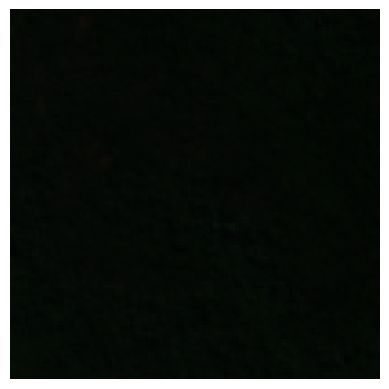

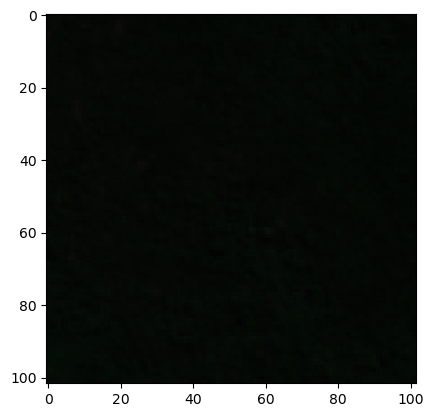

In [6]:
summary

,name,k,dasgupta_cost,l2_dist,sil_score,log10_dc,diff_l2,region
0,average,2,1.527994e+07,4713,0.198870,7.18,NaN,us-chicago
1,average,3,1.527994e+07,4712,0.169369,7.18,-1.0,us-chicago
2,average,4,1.527994e+07,4707,0.158018,7.18,-5.0,us-chicago
3,average,5,1.527994e+07,4706,-0.233171,7.18,-1.0,us-chicago
4,average,6,1.527994e+07,4701,-0.240838,7.18,-5.0,us-chicago
...,...,...,...,...,...,...,...,...
109,single,16,2.001867e+07,4689,-0.438604,7.30,0.0,us-chicago
110,single,17,2.001867e+07,4688,-0.439752,7.30,-1.0,us-chicago
111,single,18,2.001867e+07,4688,-0.439768,7.30,0.0,us-chicago
112,single,19,2.001867e+07,4685,-0.448902,7.30,-3.0,us-chicago


## Determine $k$

single
complete
average
baseline_single
baseline_complete
baseline_average


## Tables and figures
* Quantitative
  * Table of Dasgupta costs, by method and by region
  * Bar chart showing best l2 distance and associated k for each method
  * Figure showing selection of one k
* Qualitative
  * Three panels across: RGB image, baseline, constrained; qualitative colors

      name  k  dasgupta_cost  l2_dist  sil_score  log10_dc  diff_l2
0  average  2   1.527994e+07     4713   0.198870      7.18      NaN
1  average  3   1.527994e+07     4712   0.169369      7.18     -1.0
2  average  4   1.527994e+07     4707   0.158018      7.18     -5.0
3  average  5   1.527994e+07     4706  -0.233171      7.18     -1.0
4  average  6   1.527994e+07     4701  -0.240838      7.18     -5.0


,k,dasgupta_cost,l2_dist,sil_score
k,1.000000e+00,-4.126493e-17,-0.235831,-0.129682
dasgupta_cost,-4.126493e-17,1.000000e+00,0.004090,0.851965
l2_dist,-2.358314e-01,4.090093e-03,1.000000,0.115275
sil_score,-1.296819e-01,8.519649e-01,0.115275,1.000000


l2_dist  sil_score  log10_dc
best  group      name              k                               
True  experiment complete          13     2190   0.061935      7.17
      baseline   baseline_complete 3      2838   0.102171      7.91
False experiment average           18     4596  -0.487570      7.18
                 single            8      4699  -0.324767      7.30
      baseline   baseline_average  4      4711   0.630506      7.98
                 baseline_single   4      4711   0.622616      7.97

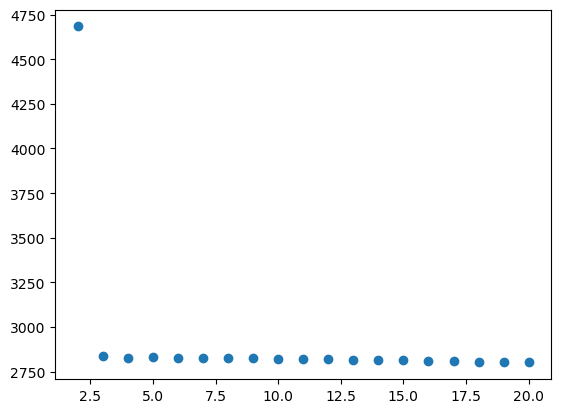

In [8]:
temp = summary[summary["name"]=="baseline_complete"].copy()
plt.scatter(temp["k"], temp["l2_dist"])

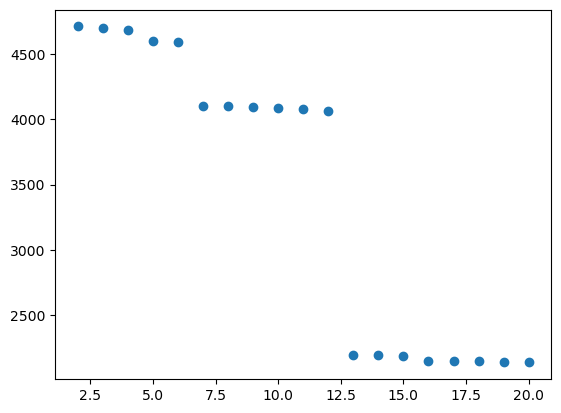

In [9]:
temp = summary[summary["name"]=="complete"].copy()
plt.scatter(temp["k"], temp["l2_dist"])

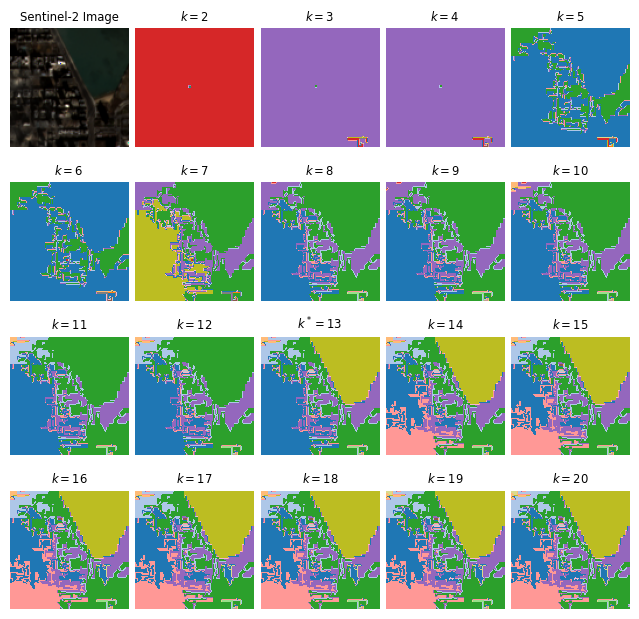

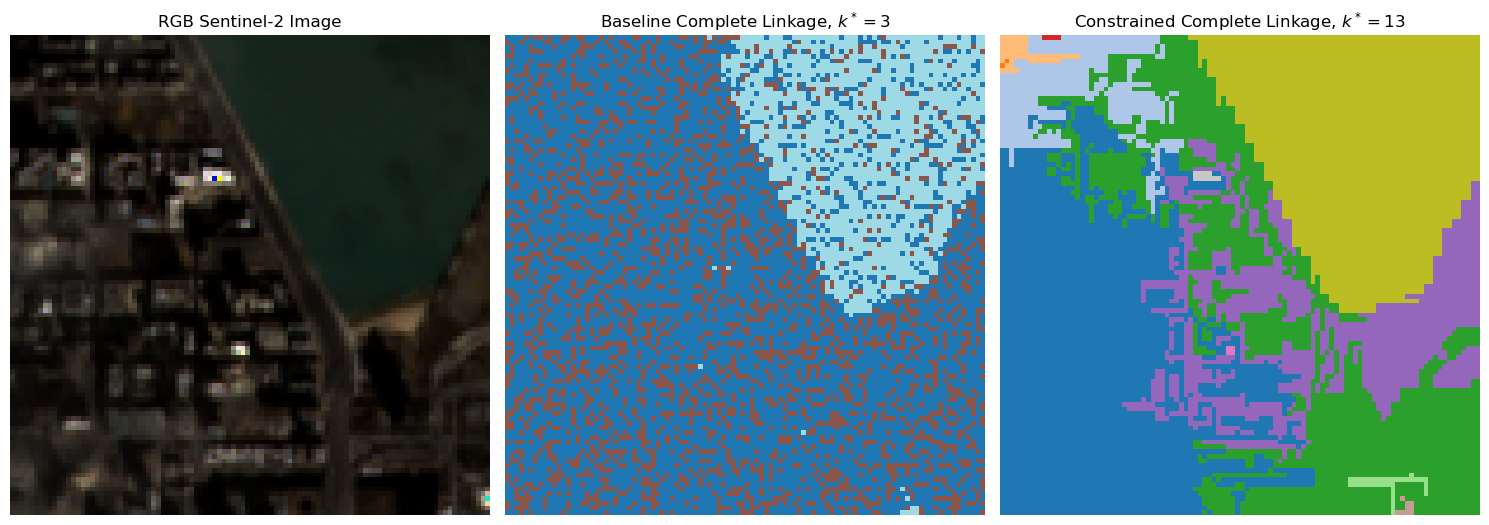